<a href="https://colab.research.google.com/github/AryanSahoo-2003/Neural-process-SRIP-/blob/main/Image_Neural_Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
from torchvision.utils import make_grid
import imageio
import random

#Getting Image Data-set

In [96]:
Image_Dataset = torch.zeros(4,3,32,32) #it is the dimension which means that 32 x 32 are the grid of images and 3 is for rgb layers
#4 is for the number of images I took from celeb dataset
device = torch.device("cpu")# as I don't have GPU
for i in range(4):
    img = imageio.imread('/Images/{}.png'.format(i + 1))
    Image_Dataset[i] = torch.Tensor(img.transpose(2, 0, 1)/255)
Image_Dataset[0][0]

<ipython-input-96-545cf5ee74d8>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('/Images/{}.png'.format(i + 1))


tensor([[0.1216, 0.2157, 0.2784,  ..., 0.3412, 0.3412, 0.3098],
        [0.1216, 0.1843, 0.2784,  ..., 0.3412, 0.3412, 0.3725],
        [0.1216, 0.2471, 0.2784,  ..., 0.3725, 0.3412, 0.3725],
        ...,
        [0.1843, 0.2157, 0.2784,  ..., 0.4353, 0.3412, 0.3098],
        [0.1843, 0.2784, 0.3725,  ..., 0.4039, 0.4667, 0.3412],
        [0.2471, 0.2157, 0.3098,  ..., 0.3412, 0.3725, 0.2471]])

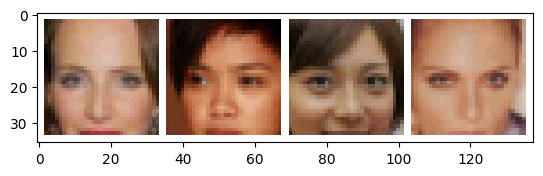

In [97]:
# Image_Grid = make_grid(Image_Dataset,nrow=4,pad_value=1.)
# plt.imshow(Image_Grid.numpy())
img_grid = make_grid(Image_Dataset, nrow=4, pad_value=1.)
plt.imshow(img_grid.permute(1, 2, 0).numpy())

In [98]:
def Context_Point(image_number,percent):
  #used for drouping out some pixels
  dropout_percent = int(32*32*percent)
  while(dropout_percent>0):
    x = random.randint(0,31)
    y = random.randint(0,31)
    if(Image_Dataset[image_number][0][x][y]>0):
      Image_Dataset[image_number][0][x][y]=0
      Image_Dataset[image_number][1][x][y]=0
      Image_Dataset[image_number][2][x][y]=0
      dropout_percent = dropout_percent-1
  plt.imshow(Image_Dataset[image_number].permute(1,2,0))


#Model

In [99]:
import torch
from torch import nn
from torch.nn import functional as F

#Here basically it takes x and y as input then feed it to encoder to make representation of dimension r
#then again to map r to dimension z which would be taken as input by decoder along with target x
class Encoder(nn.Module):
    def __init__(self, x_dim, y_dim, h_dim, r_dim):
        super(Encoder, self).__init__()

        self.x_dim = x_dim
        self.y_dim = y_dim
        self.h_dim = h_dim
        self.r_dim = r_dim

        layers = [nn.Linear(x_dim + y_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, r_dim)]

        self.input_to_hidden = nn.Sequential(*layers)

    def forward(self, x, y):
        input_pairs = torch.cat((x, y), dim=1)
        return self.input_to_hidden(input_pairs)

class MuSigmaEncoder(nn.Module):
    def __init__(self, r_dim, z_dim):
        super(MuSigmaEncoder, self).__init__()

        self.r_dim = r_dim
        self.z_dim = z_dim

        self.r_to_hidden = nn.Linear(r_dim, r_dim)
        self.hidden_to_mu = nn.Linear(r_dim, z_dim)
        self.hidden_to_sigma = nn.Linear(r_dim, z_dim)

    def forward(self, r):
        hidden = torch.relu(self.r_to_hidden(r))
        mu = self.hidden_to_mu(hidden)
        # Define sigma following convention in "Empirical Evaluation of Neural
        # Process Objectives" and "Attentive Neural Processes"
        sigma = 0.1 + 0.9 * torch.sigmoid(self.hidden_to_sigma(hidden))
        return mu, sigma


class Decoder(nn.Module):
    def __init__(self, x_dim, z_dim, h_dim, y_dim):
        super(Decoder, self).__init__()

        self.x_dim = x_dim
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.y_dim = y_dim

        layers = [nn.Linear(x_dim + z_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim),
                  nn.ReLU(inplace=True)]

        self.xz_to_hidden = nn.Sequential(*layers)
        self.hidden_to_mu = nn.Linear(h_dim, y_dim)
        self.hidden_to_sigma = nn.Linear(h_dim, y_dim)

    def forward(self, x, z):
        batch_size, num_points, _ = x.size()
        # Repeat z, so it can be concatenated with every x. This changes shape
        # from (batch_size, z_dim) to (batch_size, num_points, z_dim)
        z = z.unsqueeze(1).repeat(1, num_points, 1)
        # Flatten x and z to fit with linear layer
        x_flat = x.view(batch_size * num_points, self.x_dim)
        z_flat = z.view(batch_size * num_points, self.z_dim)
        # Input is concatenation of z with every row of x
        input_pairs = torch.cat((x_flat, z_flat), dim=1)
        hidden = self.xz_to_hidden(input_pairs)
        mu = self.hidden_to_mu(hidden)
        pre_sigma = self.hidden_to_sigma(hidden)
        # Reshape output into expected shape
        mu = mu.view(batch_size, num_points, self.y_dim)
        pre_sigma = pre_sigma.view(batch_size, num_points, self.y_dim)
        # Define sigma following convention in "Empirical Evaluation of Neural
        # Process Objectives" and "Attentive Neural Processes"
        sigma = 0.1 + 0.9 * F.softplus(pre_sigma)
        return mu, sigma

In [100]:
def img_mask_to_np_input(img, mask, normalize=True):
    #x is basically the location whereas y will be the intensity
    batch_size, num_channels, height, width = img.size()
    mask_img_size = mask.unsqueeze(1).repeat(1, num_channels, 1, 1)
    num_points = mask[0].nonzero().size(0)
    nonzero_idx = mask.nonzero()
    x = nonzero_idx[:, 1:].view(batch_size, num_points, 2).float()
    y = img[mask_img_size].view(batch_size, num_channels, num_points)
    y = y.permute(0, 2, 1)
    if normalize:
        x = (x - float(height) / 2) / (float(height) / 2)
        y -= 0.5

    return x, y



In [101]:
def xy_to_img(x, y, img_size):
    # for reconstructing the images from x and y(location and intensity)
    _, height, width = img_size
    batch_size, _, _ = x.size()
    # Unnormalize x and y
    x = x * float(height / 2) + float(height / 2)
    x = x.long()
    y += 0.5
    # Permute y so it matches order expected by image
    # (batch_size, num_points, num_channels) -> (batch_size, num_channels, num_points)
    y = y.permute(0, 2, 1)
    # Initialize empty image
    img = torch.zeros((batch_size,) + img_size)
    for i in range(batch_size):
        img[i, :, x[i, :, 0], x[i, :, 1]] = y[i, :, :]
    return img


In [102]:
def inpaint(model, img, context_mask, device):
    """
    Given an image and a set of context points, the model samples pixel
    intensities for the remaining pixels in the image.

    """
    is_training = model.neural_process.training
    model.neural_process.training = False
    target_mask = 1 - context_mask  # All pixels which are not in context
    img_batch = img.unsqueeze(0).to(device)
    context_batch = context_mask.unsqueeze(0).to(device)
    target_batch = target_mask.unsqueeze(0).to(device)
    p_y_pred = model(img_batch, context_batch, target_batch)
    x_target, _ = img_mask_to_np_input(img_batch, target_batch)
    # Using the mean parameter of normal distribution as predictions for y_target
    img_rec = xy_to_img(x_target.cpu(), p_y_pred.loc.detach().cpu(), img.size())
    img_rec = img_rec[0]  # Remove batch dimension
    # Add context points back to image
    context_mask_img = context_mask.unsqueeze(0).repeat(3, 1, 1)
    img_rec[context_mask_img] = img[context_mask_img]
    # Reset model to mode it was in before inpainting
    model.neural_process.training = is_training
    return img_rec

In [103]:
from torch.distributions import Normal
class NeuralProcess(nn.Module):
    """
    Same as above model for custom dimensions
    """
    def __init__(self, x_dim, y_dim, r_dim, z_dim, h_dim):
        super(NeuralProcess, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.r_dim = r_dim
        self.z_dim = z_dim
        self.h_dim = h_dim

        # Initialize networks
        self.xy_to_r = Encoder(x_dim, y_dim, h_dim, r_dim)
        self.r_to_mu_sigma = MuSigmaEncoder(r_dim, z_dim)
        self.xz_to_y = Decoder(x_dim, z_dim, h_dim, y_dim)

    def aggregate(self, r_i):
        return torch.mean(r_i, dim=1)

    def xy_to_mu_sigma(self, x, y):
        batch_size, num_points, _ = x.size()
        # Flatten tensors, as encoder expects one dimensional inputs
        x_flat = x.view(batch_size * num_points, self.x_dim)
        y_flat = y.contiguous().view(batch_size * num_points, self.y_dim)
        # Encode each point into a representation r_i
        r_i_flat = self.xy_to_r(x_flat, y_flat)
        # Reshape tensors into batches
        r_i = r_i_flat.view(batch_size, num_points, self.r_dim)
        # Aggregate representations r_i into a single representation r
        r = self.aggregate(r_i)
        # Return parameters of distribution
        return self.r_to_mu_sigma(r)

    def forward(self, x_context, y_context, x_target, y_target=None):
        batch_size, num_context, x_dim = x_context.size()
        _, num_target, _ = x_target.size()
        _, _, y_dim = y_context.size()

        if self.training:
            mu_target, sigma_target = self.xy_to_mu_sigma(x_target, y_target)
            mu_context, sigma_context = self.xy_to_mu_sigma(x_context, y_context)
            q_target = Normal(mu_target, sigma_target)
            q_context = Normal(mu_context, sigma_context)
            z_sample = q_target.rsample()
            # Get parameters of output distribution
            y_pred_mu, y_pred_sigma = self.xz_to_y(x_target, z_sample)
            p_y_pred = Normal(y_pred_mu, y_pred_sigma)

            return p_y_pred, q_target, q_context
        else:
            # At testing time, encode only context
            mu_context, sigma_context = self.xy_to_mu_sigma(x_context, y_context)
            # Sample from distribution based on context
            q_context = Normal(mu_context, sigma_context)
            z_sample = q_context.rsample()
            # Predict target points based on context
            y_pred_mu, y_pred_sigma = self.xz_to_y(x_target, z_sample)
            p_y_pred = Normal(y_pred_mu, y_pred_sigma)

            return p_y_pred

In [104]:
class NeuralProcessImg(nn.Module):
    def __init__(self, img_size, r_dim, z_dim, h_dim):
        super(NeuralProcessImg, self).__init__()
        self.img_size = img_size
        self.num_channels, self.height, self.width = img_size
        self.r_dim = r_dim
        self.z_dim = z_dim
        self.h_dim = h_dim

        self.neural_process = NeuralProcess(x_dim=2, y_dim=self.num_channels,
                                            r_dim=r_dim, z_dim=z_dim,
                                            h_dim=h_dim)

    def forward(self, img, context_mask, target_mask):
        x_context, y_context = img_mask_to_np_input(img, context_mask)
        x_target, y_target = img_mask_to_np_input(img, target_mask)
        return self.neural_process(x_context, y_context, x_target, y_target)

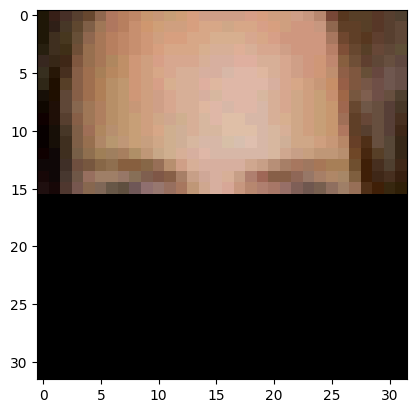

In [105]:
img = Image_Dataset[0]

# Define a binary mask to occlude image.
# the context points will be defined as the visible pixels
context_mask = torch.zeros((32, 32)).byte()
context_mask[:16, :] = 1  # Top half of pixels are visible

# Show occluded image
occluded_img = img * context_mask.float()
plt.imshow(occluded_img.permute(1, 2, 0).numpy())

In [106]:
model_celeb = '/Images/model.pt'
##already trained a celeb dataset model(wil directly link it in github)
model = NeuralProcessImg([3, 32, 32],
                         512,
                         512,
                         512)
model

NeuralProcessImg(
  (neural_process): NeuralProcess(
    (xy_to_r): Encoder(
      (input_to_hidden): Sequential(
        (0): Linear(in_features=5, out_features=512, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU(inplace=True)
        (4): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (r_to_mu_sigma): MuSigmaEncoder(
      (r_to_hidden): Linear(in_features=512, out_features=512, bias=True)
      (hidden_to_mu): Linear(in_features=512, out_features=512, bias=True)
      (hidden_to_sigma): Linear(in_features=512, out_features=512, bias=True)
    )
    (xz_to_y): Decoder(
      (xz_to_hidden): Sequential(
        (0): Linear(in_features=514, out_features=512, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU(inplace=True)
        (4): Linear(in_features=512, out_features=512, bias=True)
        (5): ReLU(inpl

In [107]:
model.load_state_dict(torch.load(model_celeb, map_location=lambda storage, loc: storage))

<All keys matched successfully>

<ipython-input-100-9e0c20a64144>:8: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  y = img[mask_img_size].view(batch_size, num_channels, num_points)
<ipython-input-102-245a1eeb91af>:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  img_rec[context_mask_img] = img[context_mask_img]


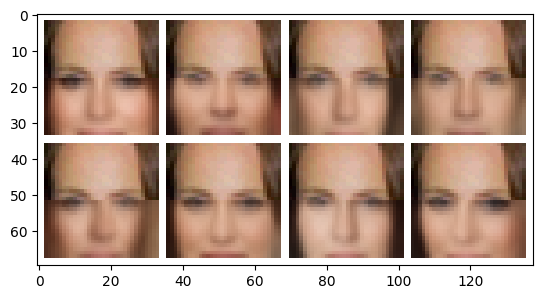

In [108]:
num_inpaintings = 8  # Number of inpaintings to sample from model
all_inpaintings = torch.zeros(num_inpaintings, 3, 32, 32)

# Sample several inpaintings
for i in range(num_inpaintings):
    all_inpaintings[i] = inpaint(model, img, context_mask, device)

# Visualize inpainting results on a grid
inpainting_grid = make_grid(all_inpaintings, nrow=4, pad_value=1.)
plt.imshow(inpainting_grid.permute(1, 2, 0).numpy())

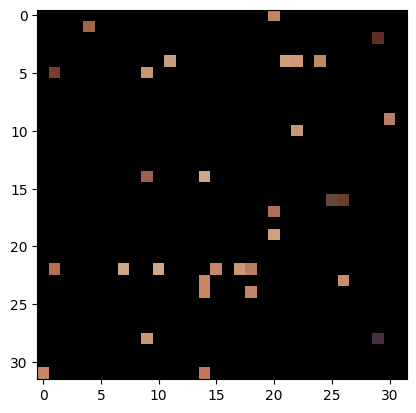

In [117]:
context_mask = (torch.Tensor(32, 32).uniform_() > 0.97).byte()

# Visualize occluded image
occluded_img_1 = Image_Dataset[3] * context_mask.float()
plt.imshow(occluded_img_1.permute(1, 2, 0).numpy())


<ipython-input-100-9e0c20a64144>:8: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  y = img[mask_img_size].view(batch_size, num_channels, num_points)
<ipython-input-102-245a1eeb91af>:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  img_rec[context_mask_img] = img[context_mask_img]


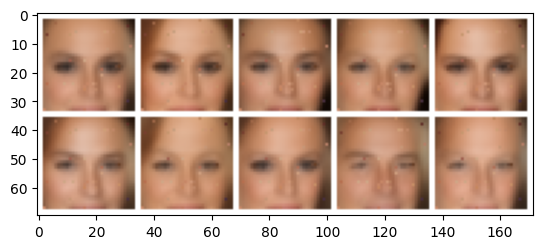

In [118]:
num_inpaintings = 10  # Number of inpaintings to sample from model
all_inpaintings = torch.zeros(num_inpaintings, 3, 32, 32)

# Sample several inpaintings
for i in range(num_inpaintings):
    all_inpaintings[i] = inpaint(model, occluded_img_1, context_mask, device)

# Visualize inpainting results on a grid
inpainting_grid = make_grid(all_inpaintings, nrow=5, pad_value=1.)
plt.imshow(inpainting_grid.permute(1, 2, 0).numpy())

##We can see here that even though 97% of the image pixels have been gone,it still shows good results(can be used for creating similiar images)
